In [1]:
import warnings
warnings.filterwarnings('ignore')

## load data

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = r"D:\OneDrive - University of Edinburgh\paper\Spatio-temporal RSV\TAP-RSV 2\RSV\data"
rsv = pd.read_csv(os.path.join(data_path, "CDC.csv"), low_memory=False)
rsv.drop_duplicates(subset=['State', 'Season', 'MMWR Week', 'Week ending date', 'Age Category', \
       'Sex', 'Race'], keep="last", inplace=True)
rsv.dropna(inplace=True)

### data process

In [3]:
# get pediatric weekly statistics in these states 
rsv = rsv[rsv["Age Category"] == '0-17 (Children)']
states = ['Michigan', 'Minnesota', 'New Mexico',
       'New York', 'Oregon', 'Georgia', 'Maryland', 'Tennessee',
       'California', 'Colorado', 'Connecticut', 'Utah']
rsv = rsv[rsv.State.isin(states)]

weeks = rsv["Week ending date"].unique()[1:]
rsv = rsv[rsv["Week ending date"].isin(weeks)]
rsv = rsv[rsv.Sex == "Overall"]
rsv = rsv[rsv.Race == "Overall"]
rsv = rsv[rsv["MMWR Week"] != "Overall"]

def t(x):
    x = x[:-12]
    tmp = x.split('/')
    tmp = [tmp[-1], tmp[0], tmp[1]]
    return "/".join(tmp)

rsv["right_time"] = rsv["Week ending date"]
rsv["right_time"] = rsv["right_time"].apply(lambda x: t(x))
rsv = rsv.sort_values(["right_time"])
weeks = rsv["Week ending date"].unique()

In [4]:
data = []
state_weeks = []

def t(x):
    x = x[:-12]
    tmp = x.split('/')
    tmp = [tmp[-1], tmp[0], tmp[1]]
    return "/".join(tmp)

for s_idx, s in enumerate(states):
    tmp = rsv[rsv.State == s]
#     for v in tmp.values:
#         for j in v:
#             print (j, end=" ")
#         print()
#     aa
    data.append(tmp.Rate.tolist().copy())
    state_weeks.append(tmp["Week ending date"].tolist().copy())
    

### plot the trend

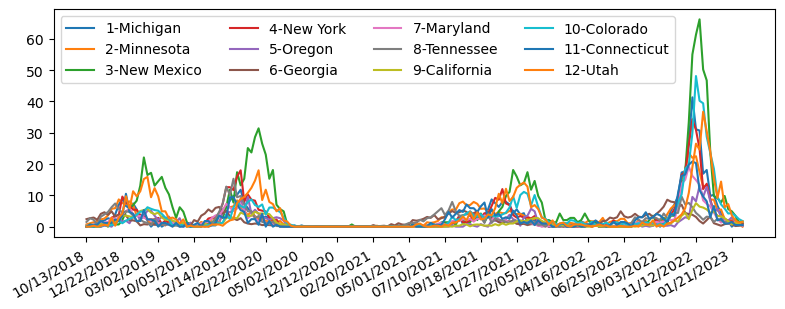

In [5]:
week_map = {week: idx for idx, week in enumerate(weeks)}

plt.figure(figsize=(8, 3.2))
for s_idx, s in enumerate(states):
    plt.plot([week_map[item] for item in state_weeks[s_idx]], data[s_idx], label=f"{s_idx+1}-{states[s_idx]}")

plt.xticks(np.arange(len(weeks))[::10], [item[:-12] for item in weeks[::10]], rotation=30, fontsize=10, ha="right")
plt.legend(ncols=4)
plt.tight_layout()
print ()

# NTF module

In [6]:
def optimize(A, B, D, reg=1e-6):
    u = np.linalg.solve(A + reg * D, B)
    return u

def initialize(T, R, device):
    return *[np.random.random((I, R)) for I in T.shape], np.eye(R)

def NTF_2d(T, A1, A2, D, iteration=200, reg=1e-3, verbose=True):
    interval = iteration // 10
    for i in range(iteration):
        A1 = optimize((A2.T@A2), np.einsum('ij,jr->ri',T,A2, optimize=True), D).T
        A1 = np.clip(A1, a_min=1e-8, a_max=200)
        A1 -= A1.max(1)[0].reshape(-1, 1) * reg * (A1 == np.abs(A1)) * np.ones_like(A1)
        A1 = np.clip(A1, a_min=1e-8, a_max=200)
        
        A2 = optimize((A1.T@A1), np.einsum('ij,ir->rj',T,A1, optimize=True), D).T
        A2 = np.clip(A2, a_min=1e-8, a_max=200)
            
        if verbose:
            if i % interval == interval - 1:
                rec = np.einsum('ir,jr->ij',A1,A2, optimize=True)
                loss = (np.linalg.norm(rec - T) / np.linalg.norm(T))**2
                print ('{}/{}'.format(i, iteration), 'fitness loss:', loss.item())
        
        scale1 = (A1**2).sum(0) ** 0.5
        scale2 = (A2**2).sum(0) ** 0.5
        scale = (scale1 * scale2) ** (1/2)

        A1 = A1 / scale1.reshape(1, -1) * scale.reshape(1, -1)
        A2 = A2 / scale2.reshape(1, -1) * scale.reshape(1, -1)
            
    result = [A1, A2]
    return result

In [7]:
data = np.array(data)
np.random.seed(100)
R = 3
result = NTF_2d(data, *initialize(data, R=R, device='cpu'), reg=1e-1, iteration=100)

9/100 fitness loss: 0.05604601168167744
19/100 fitness loss: 0.054985972777560184
29/100 fitness loss: 0.05422099125918878
39/100 fitness loss: 0.05216482173646161
49/100 fitness loss: 0.053024036323025533
59/100 fitness loss: 0.05453717843514625
69/100 fitness loss: 0.05456504610772707
79/100 fitness loss: 0.05455987964793165
89/100 fitness loss: 0.05455925224359396
99/100 fitness loss: 0.05455919624036775


In [8]:
# change the color order
result[1] = result[1][:, [1, 2, 0]]

In [9]:
weeks[-1][:11]

'02/11/2023 '

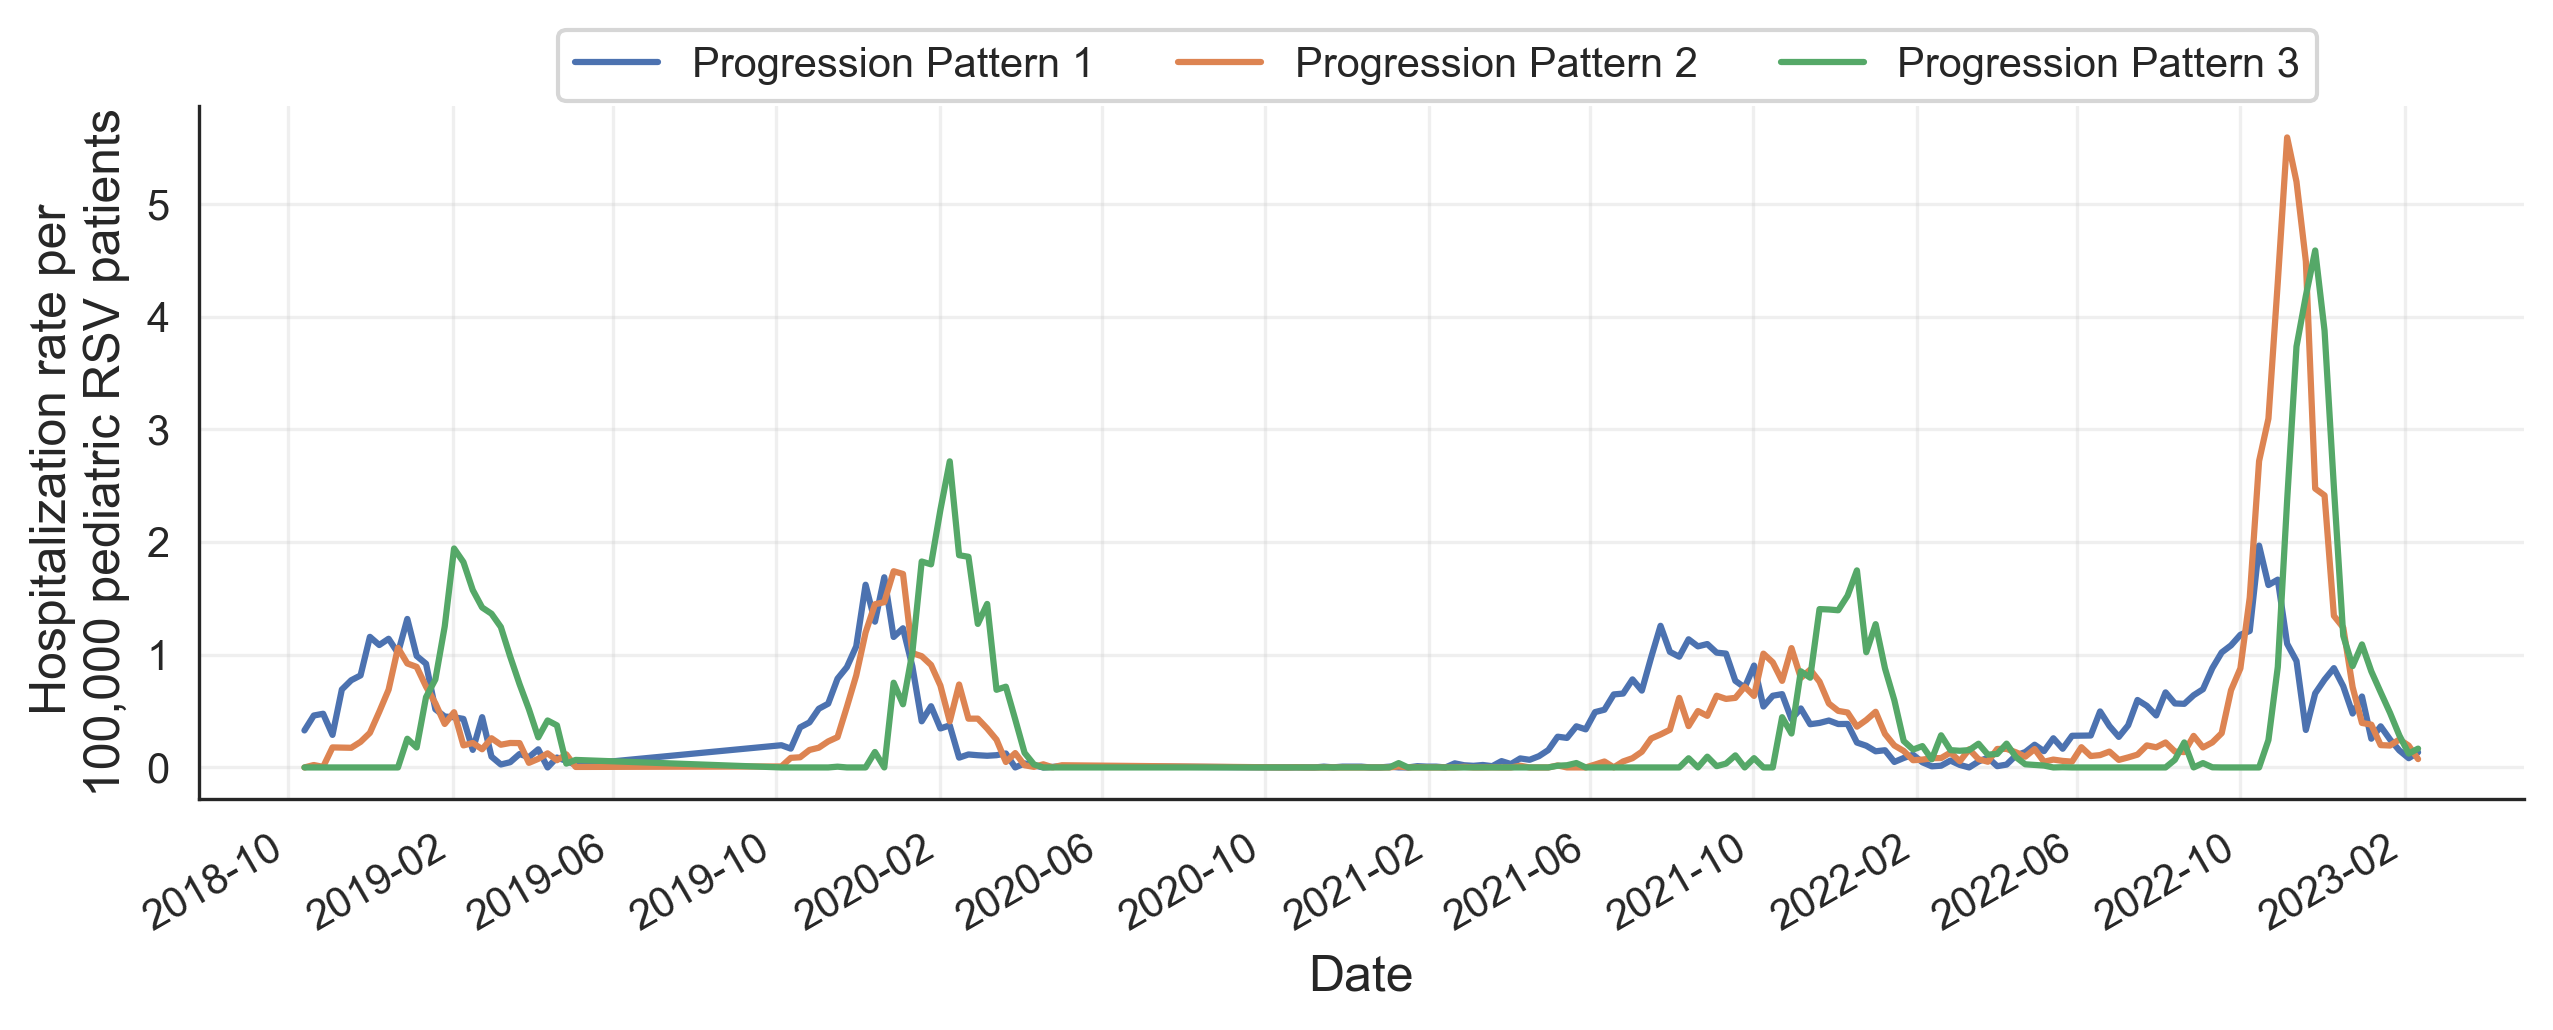

In [11]:
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

sns.set_style("white")
sns.set_palette("deep")
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
x_date = [datetime.strptime(d[:10],'%m/%d/%Y').date() for d in weeks]
for i in range(R):
    plt.plot(x_date, result[1][:, i], label=f"Progression Pattern {i+1}")
#plt.xticks(np.arange(len(x_date))[3::8], [item[:-12] for item in x_date[3::8]], rotation=30, fontsize=10, ha="right")
myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right', fontsize=10)
# plt.ylim([-0.5, 5.8])
plt.ylabel("Hospitalization rate per \n100,000 pediatric RSV patients", fontsize=12)
plt.xlabel("Date", fontsize=12)
ax.grid(alpha=.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(ncols=3, bbox_to_anchor=(0.92,1.14))
plt.savefig("../fig/cdc_hos_rate.png", bbox_inches='tight', dpi=300)

# plot the shift of raw trend data

In [17]:
sorted_states = ['Georgia', 'Tennessee',  'Minnesota', 'Connecticut', 'Michigan', 'Maryland', 'New York', 'New Mexico', \
                'Colorado', 'Utah', 'Oregon', 'California']

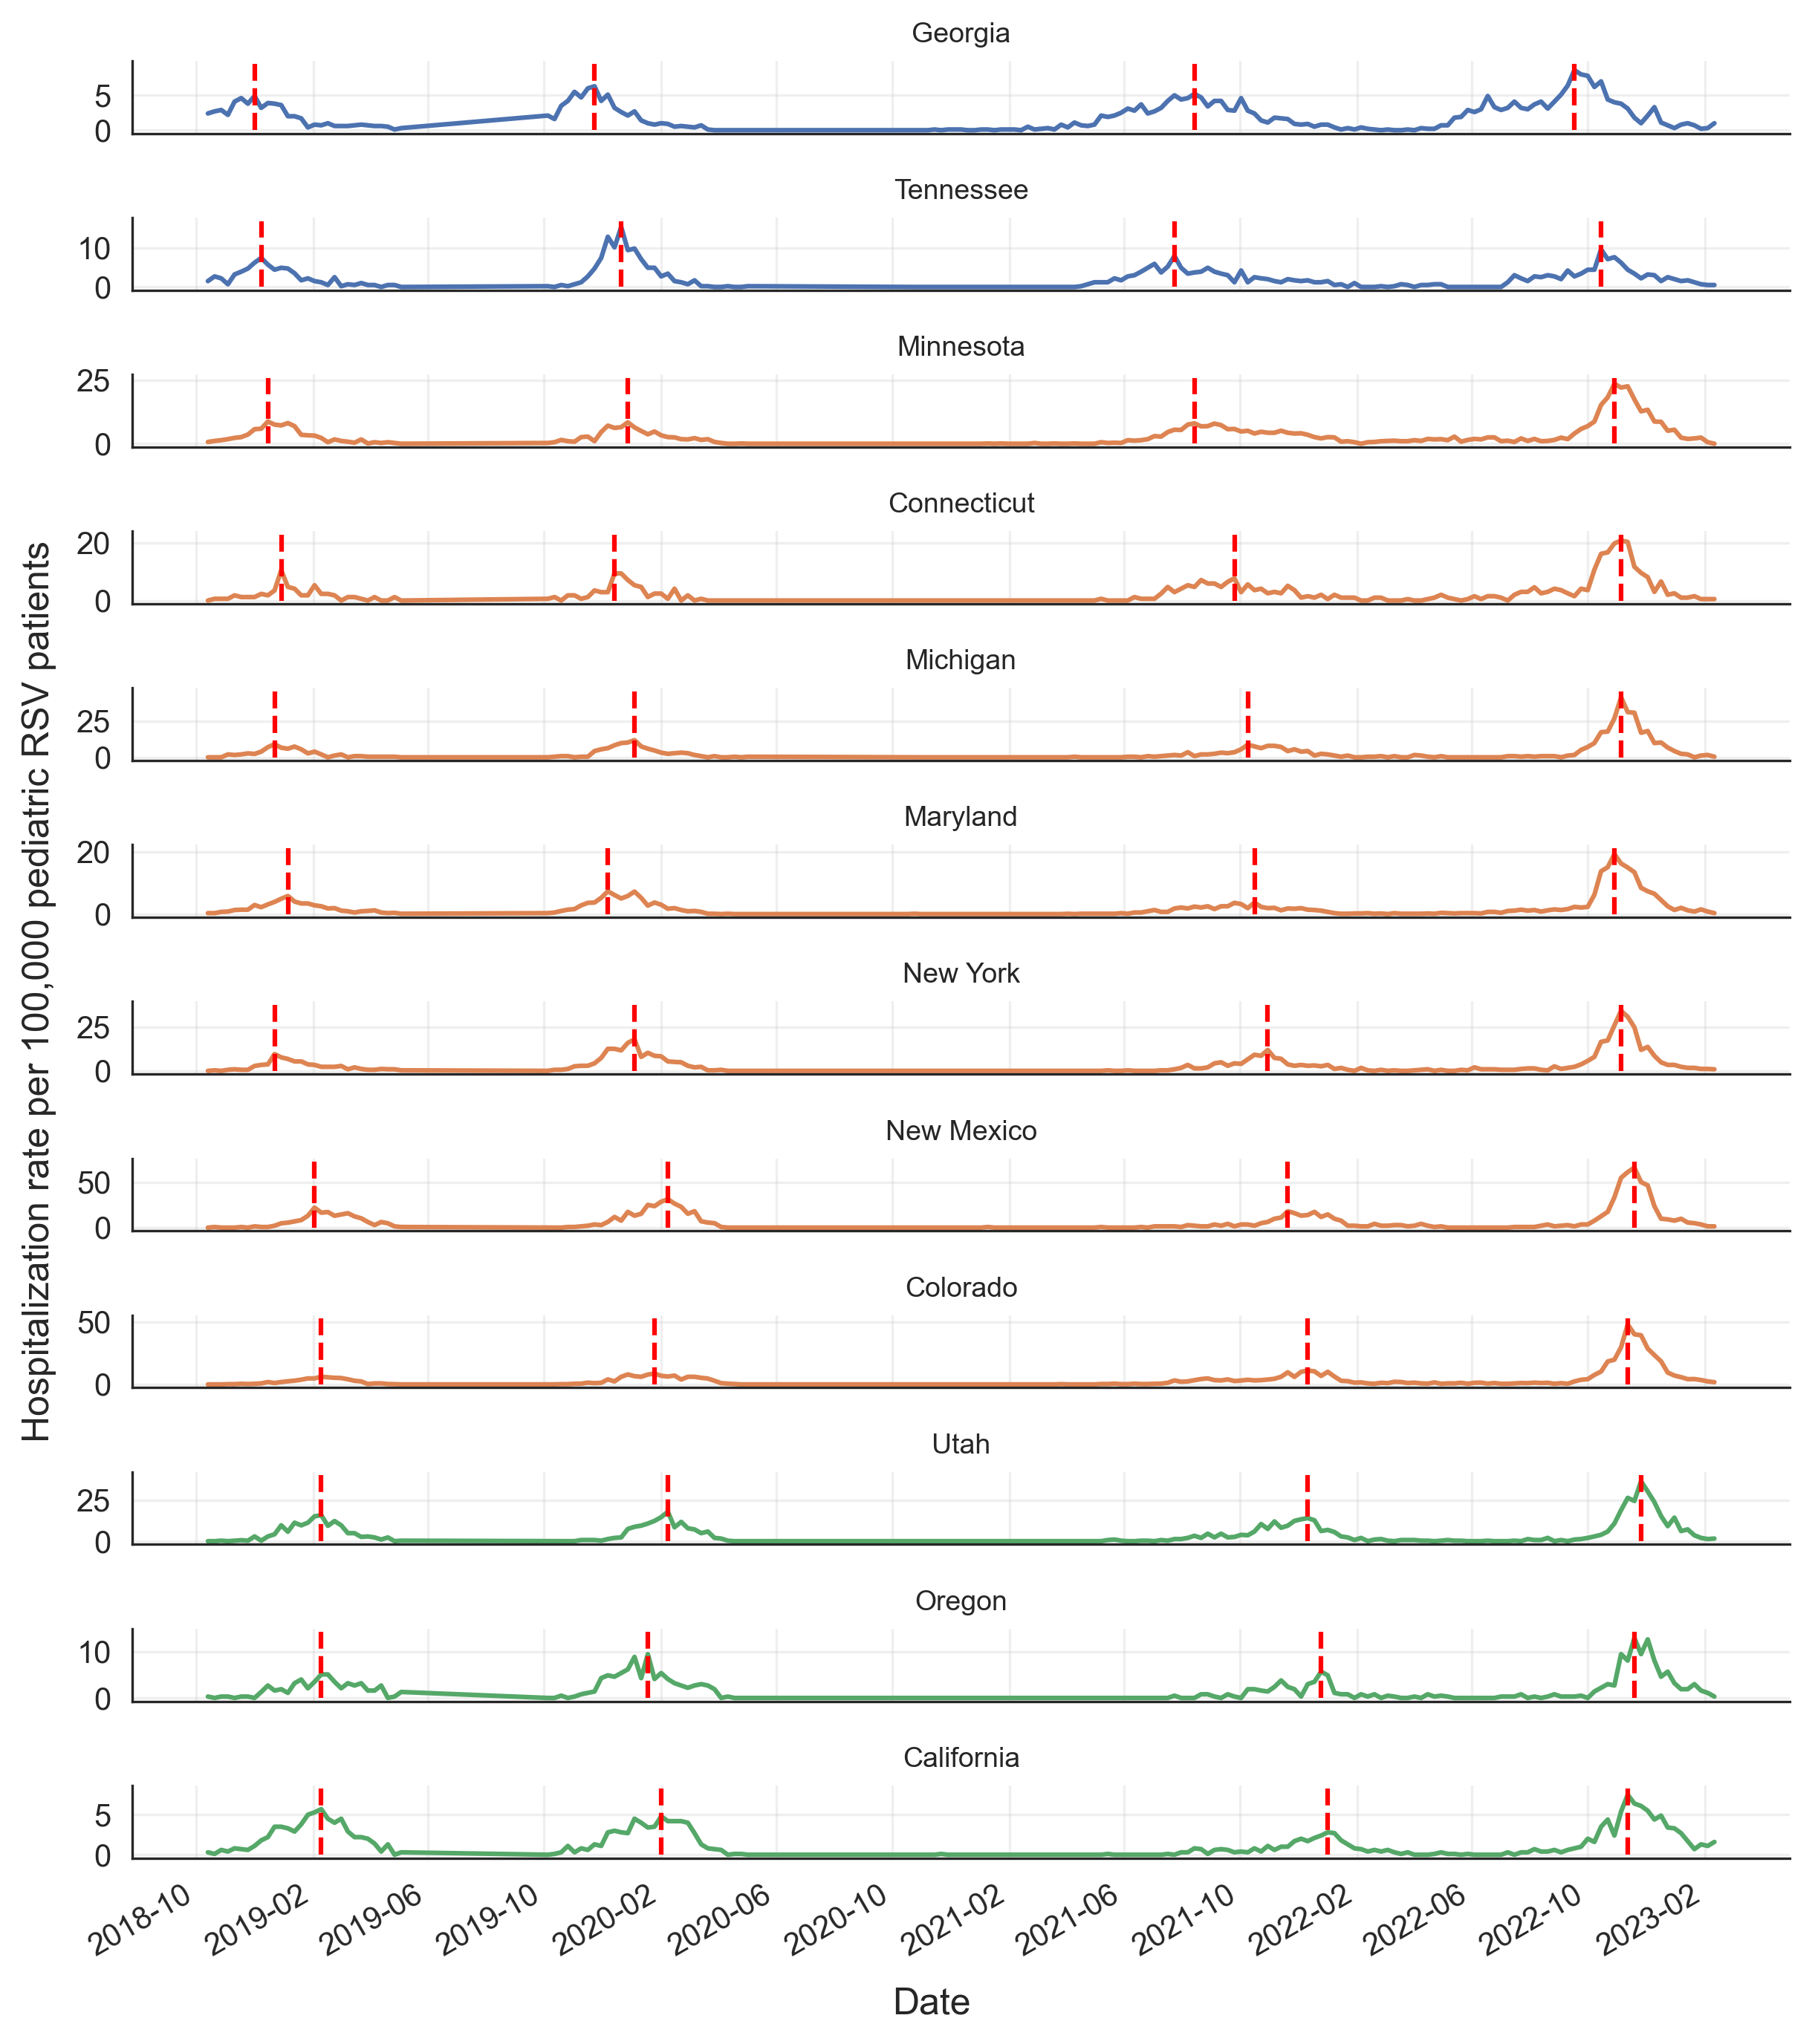

In [18]:
fig = plt.figure(figsize=(8, 9), dpi=300)
for i, state in enumerate(sorted_states):
    ax = plt.subplot(12, 1, i+1)
    if i == 0 or i == 1:
        c = sns.color_palette("deep")[0]
    elif i>1 and i<=8:
        c = sns.color_palette("deep")[1]
    else:
        c = sns.color_palette("deep")[2]
    plt.plot(x_date, data[states.index(state)], label=f"{state}", color=c)
    ax.grid(alpha=.3)
    #plt.xticks(np.arange(-35, -1), [])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    if i == 11:
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right', fontsize=10)
    else:
        ax.set_xticklabels([])
    
    timepoint = [0, 30, 70, 150, len(x_date)]
    cur_max = data[states.index(state)].max()
    for t in range(1, len(timepoint)):
        max_point = np.argmax(data[states.index(state)][timepoint[t-1]:timepoint[t]])   
        ax.vlines(x_date[timepoint[t-1] + max_point], 0, cur_max*1.1, linestyles='dashed', color='r')
        #ax.vlines(max_point, 0, cur_max*1.1, linestyles='dashed')
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"{state}", fontsize=9)
    #plt.legend(loc=2, fontsize=10)
fig.text(0.5, -0.01, 'Date', ha='center', fontdict={'fontsize': 12})
fig.text(-0.01, 0.5, 'Hospitalization rate per 100,000 pediatric RSV patients', va='center', rotation='vertical', fontdict={'fontsize': 12})
plt.tight_layout()
plt.savefig("../fig/rsv_hos_rate_states.png", bbox_inches='tight', dpi=300)

# 

In [103]:
x_date[max_point]

datetime.date(2019, 3, 9)